# Problemas de clasificación

Mi nombre es Isai Ambrocio con matrícula A01625101 con lo cual me corresponde: **P1_1.txt**

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel, RFECV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from typing import Dict


sns.set_theme()

## Ejercicio 1

#### 1. Determina si es necesario balancear los datos. En caso de que sea afirmativo, en todo este ejercicio tendrás que utilizar alguna estrategia para mitigar el problema de tener una muestra desbalanceada.

In [2]:
SEED = 42

In [4]:
data = np.loadtxt("./P1_1.txt")
Y = data[:, 0]
X = data[:, 2:]

labels = {"Focused": 1, "Distracted": 2}

In [5]:
def plot_proportions(x: np.array, y: np.array, labels: Dict[str, int]) -> plt.figure:
    n_obs = len(y)
    categories = {k: sum(y == v) / n_obs for k, v in labels.items()}

    plt.figure(figsize=(6, 6))
    plt.title(f"Proportion of target variable, {n_obs} samples")
    plt.pie(categories.values(), labels=categories.keys(), autopct="%.2f%%")
    plt.legend()
    return plt

#### Datos no balaneados.

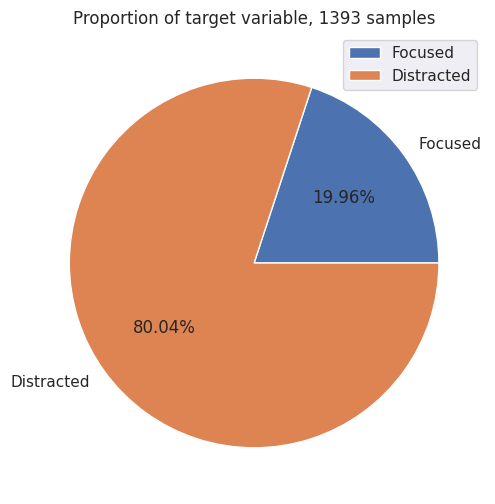

In [6]:
plot_proportions(X, Y, labels)
plt.show()

Como podemos ver, una de nuestras categorías está infrarrepresentada, lo que significa que el modelo aprenderá principalmente de los casos "distraídos" y no de los "centrados". Dado que el conjunto de datos es bastante pequeño, no nos beneficiaría reducir el muestreo de la clase mayoritaria; en su lugar, aplicaremos la *Técnica Sintética de Sobremuestreo de Minorías (SMOTE)* para aumentar el muestreo de la clase minoritaria.

In [7]:
X_balanced, Y_balanced = SMOTE(random_state=SEED).fit_resample(X, Y)

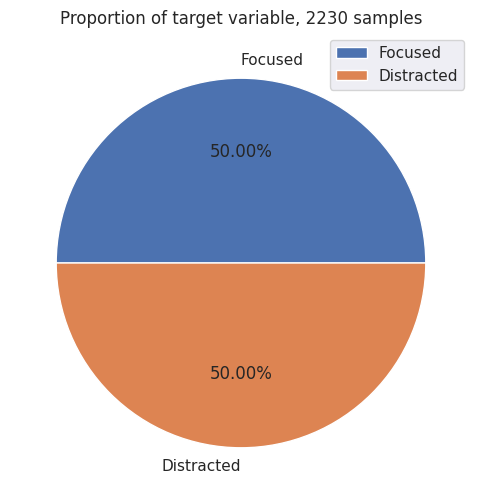

In [8]:
plot_proportions(X_balanced, Y_balanced, labels)
plt.show()

Ahora podemos empezar a trabajar con un conjunto de datos equilibrado.

#### 2. Evalúa al menos 5 modelos de clasificación distintos utilizando validación cruzada, y determina cuál de ellos es el más efectivo.



En primer lugar, intentaremos ajustar el conjunto de datos desequilibrados para ver si el sobremuestreo influye en el rendimiento de nuestros modelos. En este caso, la puntuación de precisión no proporcionará ninguna información útil, por lo que utilizaremos `ROC AUC` y `F1` como métricas para el conjunto de datos desequilibrado.

In [9]:
imbalanced_models = {
    "Logistic Regression": LogisticRegression(random_state=SEED),
    "SVC": SVC(random_state=SEED),
    "Decision Tree": DecisionTreeClassifier(random_state=SEED),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(75, 35, 20, 10),
                                    activation="logistic",
                                    solver="lbfgs",
                                    max_iter=1000,
                                    alpha=0.00001,
                                    random_state=SEED),
    "Random Forest": RandomForestClassifier(random_state=SEED)
}

for name, model in imbalanced_models.items():
    cv_results = cross_validate(model, X, Y, cv=5, scoring=["roc_auc", "f1"])
    auc = np.mean(cv_results["test_roc_auc"])
    f1 = np.mean(cv_results["test_f1"])
    print(f"{name} - AUC={auc:.4f} - F1={f1:.4f}")

Logistic Regression - AUC=0.9308 - F1=0.7474
SVC - AUC=0.9498 - F1=0.7240
Decision Tree - AUC=0.7200 - F1=0.5410
Neural Network - AUC=0.7196 - F1=0.5658
Random Forest - AUC=0.9189 - F1=0.6027


 Aquí podemos ver que el clasificador SVM tuvo la mejor puntuación AUC (0,9498), lo que significa que es bastante bueno separando ambas clases, por otro lado, la puntuación F1 (0,724) no implica que sea tan bueno capturando casos positivos a la vez que preciso (recall & precision).

Ahora probemos a utilizar el conjunto de datos equilibrado e incluyamos la puntuación de precisión.

In [10]:
balanced_models = {
    "Logistic Regression": LogisticRegression(random_state=SEED,
                                              max_iter=5000),
    "SVC": SVC(random_state=SEED),
    "Decision Tree": DecisionTreeClassifier(random_state=SEED),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(75, 35, 20, 10),
                                    activation="logistic",
                                    solver="lbfgs",
                                    max_iter=1000,
                                    alpha=0.00001,
                                    random_state=SEED),
    "Random Forest": RandomForestClassifier(random_state=SEED)
}

for name, model in balanced_models.items():
    cv_results = cross_validate(model, X_balanced, Y_balanced,
                                cv=5, scoring=["roc_auc", "f1", "accuracy"])
    auc = np.mean(cv_results["test_roc_auc"])
    f1 = np.mean(cv_results["test_f1"])
    acc = np.mean(cv_results["test_accuracy"])
    print(f"{name} - AUC={auc:.4f} - F1={f1:.4f} - Accuracy={acc:.4f}")

Logistic Regression - AUC=0.9753 - F1=0.9257 - Accuracy=0.9247
SVC - AUC=0.9948 - F1=0.9727 - Accuracy=0.9726
Decision Tree - AUC=0.8709 - F1=0.8748 - Accuracy=0.8709
Neural Network - AUC=0.9705 - F1=0.9461 - Accuracy=0.9448
Random Forest - AUC=0.9923 - F1=0.9551 - Accuracy=0.9547


Como podemos ver, las métricas mejoraron bastante en comparación con el conjunto de datos desequilibrado. En este caso, el SVM tiene claramente la mejor precisión, F1 y AUC, pero podríamos argumentar que el rendimiento del modelo logístico es lo suficientemente bueno, además de ser el más fácil de interpretar.

#### 3. Implementa desde cero el método de regresión logística, y evalúalo con el conjunto de datos.


El modelo de regresión logística transforma el componente lineal en valores en $[0, 1]$ utilizando la función logística:

$$ \sigma(x) = \frac{e^x}{1 + e^x} $$

Si suponemos que $X$ son *variables aleatorias independientes e idénticamente distribuidas (iid)* que siguen una distribución Bernoulli, podemos encontrar los parámetros $\beta$ que dan el mejor ajuste a los datos utilizando el *Estimador de Máxima Verosimilitud (MLE)*, que es la probabilidad de que el conjunto de datos dado sea producido por una función logística particular.


Sea $P(Y_i | X_i\beta) = \sigma(X_i\beta)$, entonces la función MLE de una función de distribución Bernoulli se define como:

$$ \mathcal{L}(\mathcal{B}) = \prod_{i=1}^n P(y_i | X_i \beta_i)$$
$$ \mathcal{L}(\mathcal{B}) = \prod_{i=1}^n (\sigma(X_i\beta))^{y_i} (1 - \sigma(X_i\beta))^{1-y_i} $$

Podemos aplicar un logaritmo para maximizar la log-verosimilitud, ya que es una función creciente:

$$ \mathcal{l}(\mathcal{B}) = \log \prod_{i=1}^n (\sigma(X_i\beta))^{y_i} (1 - \sigma(X_i\beta))^{1-y_i} $$

Usando la propiedad de producto de un logaritmo, podemos trabajar con la suma de logaritmos en lugar del producto:

$$ \mathcal{l}(\mathcal{B}) = \sum_{i=1}^n \log((\sigma(X_i\beta))^{y_i} (1 - \sigma(X_i\beta))^{1-y_i}) $$

Dividiendo el producto:

$$ \mathcal{l}(\mathcal{B}) = \sum_{i=1}^n \left[ \log((\sigma(X_i\beta))^{y_i}) + \log( (1 - \sigma(X_i\beta))^{1-y_i}) \right ] $$

Utilizando la propiedad de potencia:

$$ \mathcal{l}(\mathcal{B}) = \sum_{i=1}^n \left[ y_i \log \sigma(X_i\beta) + (1-y_i) \log(1 - \sigma(X_i\beta)) \right ] $$

Podemos utilizar esta función de log-verosimilitud como una función de pérdida (entropía cruzada binaria) invirtiendo el signo para maximizar la log-verosimilitud como un problema de minimización:

$$ L_{BCE} = - \mathcal{l}(\mathcal{B}) $$
$$ L_{BCE} = - \sum_{i=1}^n \left[ y_i \log \sigma(X_i\beta) + (1-y_i) \log(1 - \sigma(X_i\beta)) \right ] $$

Ahora que tenemos una función de pérdida, podemos optimizar los parámetros $\beta$ minimizando la pérdida media en todas las muestras:

$$ \hat{\beta} =  \text{argmin}_{\beta} \frac{1}{n} \sum_{i=1}^n L_{BCE}(X_i\beta, y_i) $$

Utilizando el algoritmo de descenso de gradiente, actualizaremos iterativamente los parámetros $\beta$:

$$ \beta_{t+1} = \beta{t} - \alpha \nabla_\beta L_{BCE}(X\beta, Y) $$

Vamos a obtener la derivada parcial de la función de coste con respecto a un único parámetro $\beta_p$ y una única muestra:

$$ \frac{\partial L_{BCE}}{\partial \beta_p} = - \frac{\partial}{\partial \beta_p} \left[ y \log \sigma(X\beta_p) + (1-y) \log(1 - \sigma(X\beta_p)) \right ] $$

$$ \frac{\partial L_{BCE}}{\partial \beta_p} = -  \left[ \frac{y}{\sigma(X\beta_p)}\frac{\partial \sigma(X\beta_p)}{\partial \beta_p}  + \frac{1-y}{1 - \sigma(X\beta_p)} \frac{-\partial \sigma(X\beta_p)}{\partial \beta_p} \right ] $$

$$ \frac{\partial L_{BCE}}{\partial \beta_p} = -  \left[ \frac{y}{\sigma(X\beta_p)}\frac{\partial \sigma(X\beta_p)}{\partial \beta_p}  - \frac{1-y}{1 - \sigma(X\beta_p)} \frac{\partial \sigma(X\beta_p)}{\partial \beta_p} \right ] $$

$$ \frac{\partial L_{BCE}}{\partial \beta_p} = -  \left[ \frac{\partial \sigma(X\beta_p)}{\partial \beta_p} \left ( \frac{y}{\sigma(X\beta_p)} - \frac{1-y}{1 - \sigma(X\beta_p)} \right) \right ] $$

$$ \frac{\partial L_{BCE}}{\partial \beta_p} = -  \left[ \frac{\partial \sigma(X\beta_p)}{\partial \beta_p} \left ( \frac{y - y\sigma(X\beta_p)) - \sigma(X\beta_p) + y\sigma(X\beta_p))}{\sigma(X\beta_p)(1 - \sigma(X\beta_p))} \right) \right ] $$

$$ \frac{\partial L_{BCE}}{\partial \beta_p} = -  \left[ \frac{\partial \sigma(X\beta_p)}{\partial \beta_p} \left ( \frac{y - \sigma(X\beta_p)}{\sigma(X\beta_p)(1 - \sigma(X\beta_p))} \right) \right ] $$

$$ \frac{\partial \sigma(X\beta_p)}{\partial \beta_p} = \sigma(X\beta_p)(1 - \sigma(X\beta_p)) X $$

$$ \frac{\partial L_{BCE}}{\partial \beta_p} = -  \left[ \frac{\sigma(X\beta_p)(1 - \sigma(X\beta_p)) X(y - \sigma(X\beta_p))}{\sigma(X\beta_p)(1 - \sigma(X\beta_p))}  \right ] $$

$$ \frac{\partial L_{BCE}}{\partial \beta_p} = -  \left[ (y - \sigma(X\beta_p)X)  \right ] $$

$$ \frac{\partial L_{BCE}}{\partial \beta_p} = \left( \sigma(X\beta_p) - Y \right) X$$


In [ ]:
class LogisticModel:

    def __init__(self, random_state: int = 42, learning_rate: float = 0.0001):
        self.random_state = random_state
        self.learning_rate = learning_rate
        self.n = None
        self.p = None
        self.beta = None

    @staticmethod
    def __sigmoid(x):
        return 1 / (1 + np.exp(-x))

    def fit(self, X, y, iters=500):
        np.random.seed(self.random_state)

        self.n, self.p = X.shape
        self.beta = np.random.rand(self.p)

        for _ in range(iters):
            y_hat = self.__sigmoid(1)
            self.beta = self.beta - self.learning_rate * (y_hat - y).dot(X)

        return self

    def predict(self, X):
        return np.round(self.__sigmoid(X.dot(self.beta)))

    def predict_proba(self, X):
        return self.__sigmoid(X.dot(self.beta))

In [ ]:
Y_bin = np.array([1 if y == 1 else 0 for y in Y])  # 1 si está concentrado, 0 si está distraído
Y_bin_balanced = np.array([1 if y == 1 else 0 for y in Y_balanced])

manual_reg = LogisticModel().fit(X, Y_bin)
reg_acc = accuracy_score(Y_bin, manual_reg.predict(X))
reg_f1 = f1_score(Y_bin, manual_reg.predict(X))

manual_reg_balanced = LogisticModel().fit(X_balanced, Y_bin_balanced)
reg_bal_acc = accuracy_score(Y_bin_balanced, manual_reg_balanced.predict(X_balanced))
reg_bal_f1 = f1_score(Y_bin_balanced, manual_reg_balanced.predict(X_balanced))

In [ ]:
print(f"Logistic Regression with imbalanced data: Acc={reg_acc} - F1={reg_f1}")
print(f"Logistic Regression with balanced data: Acc={reg_bal_acc} - F1={reg_bal_f1}")

Logistic Regression with imbalanced data: Acc=0.8255563531945441 - F1=0.5943238731218699
Logistic Regression with balanced data: Acc=0.862780269058296 - F1=0.8726061615320565


#### 4. Con alguno de los clasificadores que probaste en los pasos anteriores, determina el número óptimo de características utilizando un método tipo Filter.

In [ ]:
classifier = RandomForestClassifier(random_state=SEED)

classifier.fit(X_balanced, Y_balanced)
feature_importance = classifier.feature_importances_

sorted_indices = np.argsort(feature_importance)[::-1]

In [ ]:
num_features_list = []
accuracy_list = []
f1_score_list = []

Itera a través de diferentes números de características y selecciona las primeras `num_features` características

Número óptimo de características: 146
Mejor F1-score alcanzado: 0.9607645573161381


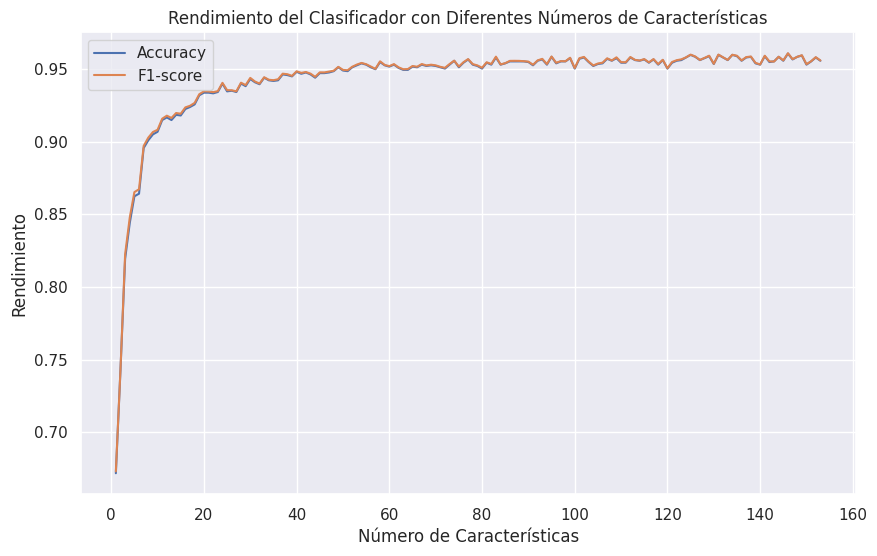

In [11]:

for num_features in range(1, len(sorted_indices) + 1):
    selected_features = X_balanced[:, sorted_indices[:num_features]]

    cv_results = cross_validate(classifier, selected_features, Y_balanced, cv=5, scoring=["accuracy", "f1"])

    accuracy_list.append(np.mean(cv_results["test_accuracy"]))
    f1_score_list.append(np.mean(cv_results["test_f1"]))
    num_features_list.append(num_features)

optimal_num_features = num_features_list[np.argmax(f1_score_list)]

print(f"Número óptimo de características: {optimal_num_features}")
print(f"Mejor F1-score alcanzado: {max(f1_score_list)}")

plt.figure(figsize=(10, 6))
plt.plot(num_features_list, accuracy_list, label="Accuracy")
plt.plot(num_features_list, f1_score_list, label="F1-score")
plt.xlabel("Número de Características")
plt.ylabel("Rendimiento")
plt.legend()
plt.title("Rendimiento del Clasificador con Diferentes Números de Características")
plt.show()


#### 5. Repite el paso anterior, pero para un método de selección de características de tipo Wrapper.

In [ ]:
classifier = RandomForestClassifier(random_state=SEED)

rfecv = RFECV(estimator=classifier, step=1, cv=5, scoring='f1')
rfecv.fit(X_balanced, Y_balanced)


optimal_num_features = min(rfecv.n_features_, X_balanced.shape[1])

print(f"Número óptimo de características: {optimal_num_features}")

In [21]:
rf_model = rfecv.estimator_
print("Importancia de Características:")
for feature_idx, importance in enumerate(rf_model.feature_importances_):
    print(f"Feature {feature_idx}: Importance {importance}")

Importancia de Características:
Feature 0: Importance 0.002837410298965963
Feature 1: Importance 0.002364397183429125
Feature 2: Importance 0.005231774380121976
Feature 3: Importance 0.004731215924333874
Feature 4: Importance 0.004046717042602036
Feature 5: Importance 0.002978383130577827
Feature 6: Importance 0.004098320583538081
Feature 7: Importance 0.004432609808538776
Feature 8: Importance 0.005429117679731053
Feature 9: Importance 0.00558996795459581
Feature 10: Importance 0.0025298744934064183
Feature 11: Importance 0.0041672511051563665
Feature 12: Importance 0.028828339082988354
Feature 13: Importance 0.05222639676841833
Feature 14: Importance 0.020288327085055225
Feature 15: Importance 0.0053238796450077695
Feature 16: Importance 0.02544758310059945
Feature 17: Importance 0.056202390887862476
Feature 18: Importance 0.06785553969451452
Feature 19: Importance 0.0557511995840854
Feature 20: Importance 0.03577023932063503
Feature 21: Importance 0.026698535512956215
Feature 22: Im

#### 6. Repite el paso 4, pero para un método de selección de características de tipo Filter-Wrapper

In [13]:
classifier = RandomForestClassifier(random_state=SEED)

sfm = SelectFromModel(classifier, threshold="median")
sfm.fit(X_balanced, Y_balanced)

num_selected_features = np.sum(sfm.get_support())

print(f"Número de características seleccionadas: {num_selected_features}")


selected_features = X_balanced[:, sfm.get_support()]
cv_results = cross_validate(classifier, selected_features, Y_balanced, cv=5, scoring=["f1"])

f1_score = np.mean(cv_results["test_f1"])

print(f"Puntuación F1 con características seleccionadas: {f1_score}")


Número de características seleccionadas: 77
Puntuación F1 con características seleccionadas: 0.9557342517953005


### Preguntas

 **¿Qué pasa si no se considera el problema de tener datos desbalanceados para este caso? ¿Por qué?**

Si no balanceamos los datos adecuadamente para este problema de clasificación binaria, nuestro modelo puede llegar a aprender bastante sobre un caso en lugar de cómo discriminar ambas clases, por lo que puede tener un 80% de accuracy si todas las predicciones son de la categoría con la mayoría de datos.

**De todos los clasificadores, ¿cuál o cuales consideras que son adecuados para los datos? ¿Qué propiedades tienen dichos modelos que los hacen apropiados para los datos? Argumenta tu respuesta.**

 En este caso considero que la regresión logística puede ser un muy buen modelo debido a que podemos explicar cada variable independiente, por otro lado, si la diferencia entre las métricas de regresión logística y SVM son bastante significativas para este problema, podríamos sacrificar un poco de interpretabilidad y utilizar la SVM.

 **¿Es posibles reducir la dimensionalidad del problema sin perder rendimiento en el modelo? ¿Por qué?**

 Podríamos utilizar SVD para reducir la cantidad de datos a una matriz equivalente, o incluso hacer un PCA y quitar las variables independientes que no aporten información.

 **¿Qué método de selección de características consideras el más adecuado para este caso? ¿Por qué?**

Elegí Random Forest como el mejor método de selección de características porque obtuvo los mejores resultados en todos los parámetros de rendimiento: AUC, F1 y precisión.

Además, Random Forest es un método de ensamble, lo que significa que combina varios modelos para mejorar el rendimiento general. Esto lo hace más robusto que los métodos individuales, como la regresión logística o SVM.

 **Si quisieras mejorar el rendimiento de tus modelos, ¿qué más se podría hacer?**

 Como ya tenemos dos modelos que resultan ser adecuados para este problema, podríamos empezar a optimizar los hiperparámetros de ellos, haciendo un problema de optimización.



## Ejercicio 2

En este ejercicio trabajarás con datos que vienen de un experimento en el que se midió actividad muscular con la técnica de la Electromiografía en el brazo derecho de varios participantes cuando éstos realizaban un movimiento con la mano entre siete posible (Flexionar hacia arriba, Flexionar hacia abajo, Cerrar la mano, Estirar la mano, Abrir la mano, Coger un objeto, No moverse). Al igual que en el ejercicio anterior, los datos se cargan con la función loadtxt de numpy. A su vez, la primera columna corresponde a la clase (1, 2, 3, 4, 5, 6, y 7), la segunda columna se ignora, y el resto de las columnas indican las variables que se calcularon de la respuesta muscular. El archivo de datos con el que trabajarás depende de tu matrícula.

In [ ]:
data_2 = np.loadtxt("./M_1.txt")
Y = data_2[:, 0]
X = data_2[:, 2:]

labels_2 = {"Flex Up": 1, "Flex Down": 2, "Close Hand": 3,
            "Flex Hand": 4, "Open Hand": 5, "Pick Object": 6,
            "Not moving": 7}

#### 1. Datos no balanceados

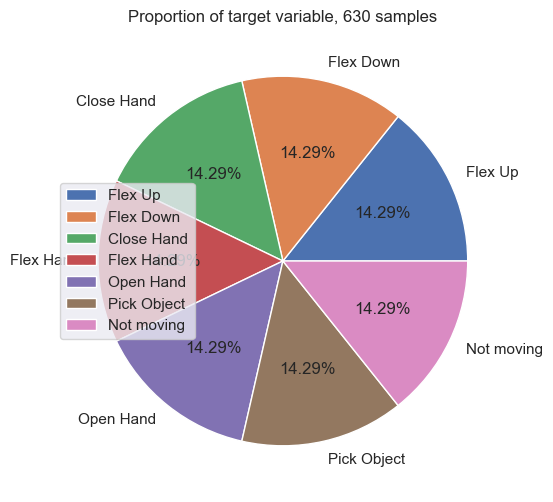

In [ ]:
plot_proportions(X, Y, labels_2)
plt.show()

> As we can see, all of our labels are balanced, no need to implement up/down sampling.

#### 2. Modelos de clasificación

In [ ]:
X.shape

(630, 630)

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(random_state=SEED, max_iter=5000),
    "SVC": SVC(random_state=SEED, max_iter=5000),
    "Decision Tree": DecisionTreeClassifier(random_state=SEED),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(300, 150, 75, 30),
                                    activation="logistic",
                                    solver="adam",
                                    max_iter=5000,
                                    alpha=0.0001,
                                    random_state=SEED),
    "Random Forest": RandomForestClassifier(random_state=SEED)
}

for name, model in models.items():
    cv_results = cross_validate(model, X, Y,
                                cv=5, scoring=["precision_macro", "recall_macro",
                                               "f1_macro", "accuracy"])
    f1 = np.mean(cv_results["test_f1_macro"])
    acc = np.mean(cv_results["test_accuracy"])
    pre = np.mean(cv_results["test_precision_macro"])
    rec = np.mean(cv_results["test_recall_macro"])
    print(f"{name} - Precision={pre:.4f} - Recall={rec:.4f} - F1={f1:.4f} - Accuracy={acc:.4f}")

Logistic Regression - Precision=0.9709 - Recall=0.9683 - F1=0.9683 - Accuracy=0.9683
SVC - Precision=0.9749 - Recall=0.9714 - F1=0.9716 - Accuracy=0.9714
Decision Tree - Precision=0.8388 - Recall=0.8254 - F1=0.8247 - Accuracy=0.8254
Neural Network - Precision=0.9652 - Recall=0.9635 - F1=0.9634 - Accuracy=0.9635
Random Forest - Precision=0.9522 - Recall=0.9492 - F1=0.9489 - Accuracy=0.9492


En este caso, los clasificadores de regresión logística y SVM tienen métricas similares, lo que significa que podemos utilizar una regresión logística simple con un rendimiento relativamente bueno.

#### 3. Ajuste de hiperparámetros

Optimizaremos los hiperparámetros de un modelo de regresión logística y SVM.

In [ ]:
lr_params = {
    'penalty': ('l1', 'l2', 'elasticnet', None),
    'C': (0.1, 1, 10, 100),
    'solver': ('newton-cg', 'sag', 'saga', 'lbfgs')
}

lr_grid_search = GridSearchCV(LogisticRegression(random_state=SEED, max_iter=5000), lr_params)
lr_grid_search.fit(X, Y)

In [ ]:
svc_params = {
    'kernel': ('sigmoid', 'poly', 'rbf', 'linear'),
    'C': (0.1, 1, 10, 100),
    'gamma': ('scale', 'auto'),
    'decision_function_shape': ('ovo', 'ovr')
}

svc_grid_search = GridSearchCV(SVC(random_state=SEED, max_iter=5000), svc_params)
svc_grid_search.fit(X, Y)

GridSearchCV(estimator=SVC(max_iter=5000, random_state=42),
             param_grid={'C': (0.1, 1, 10, 100),
                         'decision_function_shape': ('ovo', 'ovr'),
                         'gamma': ('scale', 'auto'),
                         'kernel': ('sigmoid', 'poly', 'rbf', 'linear')})

#### 4. Prepara tus modelos para producción haciendo lo siguiente:
Opten los hiperparámetros óptimos utilizando todo el conjunto de datos con validación cruzada.
Con los hiperparámetros óptimos, ajusta el modelo con todos los datos.


#### Logistic Regression

In [ ]:
lr_grid_search.best_params_

{'C': 10, 'penalty': 'l1', 'solver': 'saga'}

In [ ]:
prod_lr_model = LogisticRegression(random_state=SEED,
                                   max_iter=5000,
                                   **lr_grid_search.best_params_)
cv_results = cross_validate(prod_lr_model, X, Y, cv=5,
                            scoring=["precision_macro", "recall_macro",
                                     "f1_macro", "accuracy"])

f1 = np.mean(cv_results["test_f1_macro"])
acc = np.mean(cv_results["test_accuracy"])
pre = np.mean(cv_results["test_precision_macro"])
rec = np.mean(cv_results["test_recall_macro"])
print(f"Logistic Regression Tuned - Precision={pre:.4f} - Recall={rec:.4f} - F1={f1:.4f} - Accuracy={acc:.4f}")

Logistic Regression Tuned - Precision=0.9739 - Recall=0.9714 - F1=0.9712 - Accuracy=0.9714


| Model | Precision | Recall | F1 | Accuracy |
| --- | --- | --- | --- | --- |
Logistic Regression | 0.9709 | 0.9683 | 0.9683 | 0.9683
Hypertuned LR | 0.9739 | 0.9714 | 0.9712 | 0.9714

#### SVC

In [ ]:
svc_grid_search.best_params_

{'C': 10, 'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'rbf'}

In [ ]:
prod_svc_model = SVC(random_state=SEED, max_iter=5000, **svc_grid_search.best_params_)

cv_results = cross_validate(prod_svc_model, X, Y, cv=5,
                            scoring=["precision_macro", "recall_macro",
                                     "f1_macro", "accuracy"])

f1 = np.mean(cv_results["test_f1_macro"])
acc = np.mean(cv_results["test_accuracy"])
pre = np.mean(cv_results["test_precision_macro"])
rec = np.mean(cv_results["test_recall_macro"])
print(f"Logistic Regression Tuned - Precision={pre:.4f} - Recall={rec:.4f} - F1={f1:.4f} - Accuracy={acc:.4f}")

Logistic Regression Tuned - Precision=0.9792 - Recall=0.9778 - F1=0.9778 - Accuracy=0.9778


| Model | Precision | Recall | F1 | Accuracy |
| --- | --- | --- | --- | --- |
SVC | 0.9749 | 0.9714 | 0.9716 | 0.9714
Hypertuned SVC | 0.9792 | 0.9778 | 0.9778 | 0.9778

#### 5 Preguntas

**¿Observas un problema en cuanto al balanceo de las clases? ¿Por qué?**

 No, las categorias representan el mismo porcentaje del número de datos.

 **¿Qué modelo o modelos fueron efectivos para clasificar tus datos? ¿Observas algo especial sobre los modelos? Argumenta tu respuesta.**

En este caso, los mejores modelos fueron Regresión Logística y SVM, pero al tener resultados muy similares podríamos utilizar el más simple de ellos (regresión logística).

**¿Observas alguna mejora importante al optmizar hiperparámetros? ¿Es el resultado que esperabas? Argumenta tu respuesta.**

| Model | Precision | Recall | F1 | Accuracy |
| --- | --- | --- | --- | --- |
Logistic Regression | 0.9709 | 0.9683 | 0.9683 | 0.9683
Hypertuned LR | 0.9739 | 0.9714 | 0.9712 | 0.9714
SVC | 0.9749 | 0.9714 | 0.9716 | 0.9714
Hypertuned SVC | 0.9792 | 0.9778 | 0.9778 | 0.9778

 Si hubo alguna mejora, pero tendríamos que revisar si en el contexto del problema que estamos resolviendo vale la pena el tiempo y esfuerzo este pequeño cambio.

**¿Qué inconvenientes hay al encontrar hiperparámetros? ¿Por qué?**

 El principal es el tiempo de ejecución, al tener que re-entrenar el modelo bastantes veces se vuelve muy costoso cada uno de estos entrenamientos, en donde podemos llegar a una mejora que no fue significativa.